**Zillow Clustering Project**

**Project Goals:**
- Acquire and clean data in order to utilize visualizations, clustering methods and statistical tools to find top drivers of log error.
- Create a model that more accurately predict log error in order to increase accuracy of home value predictions.

**Findings:**
- Through exploration, top drivers were chosen to create four different models to compete with the baseline model.
- PolynomialRegressor (Model 3) model using degree of 2 narrowly performed better than the baseline model.
- Model 3 ended performing well on unseen test data set.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import sklearn.preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE

from scipy import stats

import wrangle
import explore

# **Acquire Data**
-------

In [2]:
df = wrangle.get_zillow()

In [3]:
# take a look at duplicates of rows
df.duplicated().any()

False

In [4]:
# take a look at duplicates of columns
df.columns.duplicated().any()

True

In [5]:
# first drop duplicate columns from the query
df = df.loc[:, ~df.columns.duplicated()]

In [6]:
# use my get info function to get more information about the dataframe
wrangle.get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        222 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77381 non-null  float64
 3   heatingorsystemtypeid         49440 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      206 non-null    float64
 6   airconditioningtypeid         24953 non-null  float64
 7   parcelid                      77381 non-null  int64  
 8   transactiondate               77381 non-null  object 
 9   id                            77381 non-null  int64  
 10  basementsqft                  50 non-null     float64
 11  bathroomcnt                   77381 non-null  float64
 12  bedroomcnt                    77381 non-null  float64
 13  b

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,transactiondate,id,...,taxdelinquencyyear,censustractandblock,logerror,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
34688,NaN,NaN,261.0,7.0,NaN,NaN,NaN,12757963,2017-05-10,1739011,...,NaN,6.037553e+13,-0.013477,None,None,None,Floor/Wall,Single Family Residential,None,None
52078,NaN,NaN,266.0,2.0,NaN,NaN,1.0,10845145,2017-06-29,1269572,...,NaN,6.037129e+13,0.007539,Central,None,None,Central,Condominium,None,None
39704,NaN,NaN,266.0,2.0,NaN,NaN,NaN,12440823,2017-05-25,1424503,...,NaN,6.037554e+13,0.043030,None,None,None,Central,Condominium,None,None


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
typeconstructiontypeid,222.0,6.040541e+00,5.572847e-01,4.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,1.300000e+01
storytypeid,50.0,7.000000e+00,0.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00
propertylandusetypeid,77381.0,2.618263e+02,5.141199e+00,3.100000e+01,2.610000e+02,2.610000e+02,2.660000e+02,2.750000e+02
heatingorsystemtypeid,49440.0,3.920510e+00,3.592779e+00,1.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,2.400000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
architecturalstyletypeid,206.0,7.388350e+00,2.734542e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
airconditioningtypeid,24953.0,1.813289e+00,2.967894e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
parcelid,77381.0,1.300715e+07,3.481346e+06,1.071186e+07,1.153830e+07,1.253157e+07,1.421183e+07,1.676893e+08
id,77381.0,1.495139e+06,8.609071e+05,3.490000e+02,7.520700e+05,1.497932e+06,2.240535e+06,2.982274e+06
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03


### Acquire Takeaways
- I brought in SQL data using SQL query.
- This is a large dataset with many nulls.
- There were duplicate columns but no duplicate rows.


# **Prepare and Clean**
---

In [8]:
# let's take a look at the nulls in the dataframe by column
wrangle.nulls_by_column(df)

,num_rows_missing,pct_rows_missing
typeconstructiontypeid,77159,0.997131
storytypeid,77331,0.999354
propertylandusetypeid,0,0.000000
heatingorsystemtypeid,27941,0.361083
buildingclasstypeid,77366,0.999806
...,...,...
buildingclassdesc,77366,0.999806
heatingorsystemdesc,27941,0.361083
propertylandusedesc,0,0.000000
storydesc,77331,0.999354


In [9]:
# let's take a look at the nulls in the dataframe by row
wrangle.nulls_by_row(df)

,num_cols_missing,pct_cols_missing,num_rows
0,23,33.82352941176471,2
1,24,35.294117647058826,13
2,25,36.76470588235294,24
3,26,38.23529411764706,65
4,27,39.705882352941174,316
5,28,41.17647058823529,455
6,29,42.64705882352941,5270
7,30,44.11764705882353,3455
8,31,45.588235294117645,9891
9,32,47.05882352941176,12579


In [10]:
# use my drop nulls function to drop a percentage of nulls per column and row
wrangle.drop_nulls(df, .70, .70)

,propertylandusetypeid,parcelid,transactiondate,id,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,propertylandusedesc
0,261.0,14297519,2017-01-01,1727539,3.5,4.0,3.5,3100.0,3100.0,6059.0,...,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,Single Family Residential
1,261.0,17052889,2017-01-01,1387261,1.0,2.0,1.0,1465.0,1465.0,6111.0,...,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,Single Family Residential
2,261.0,14186244,2017-01-01,11677,2.0,3.0,2.0,1243.0,1243.0,6059.0,...,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,Single Family Residential
3,261.0,12177905,2017-01-01,2288172,3.0,4.0,3.0,2376.0,2376.0,6037.0,...,0.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,Single Family Residential
4,266.0,10887214,2017-01-01,1970746,3.0,3.0,3.0,1312.0,1312.0,6037.0,...,0.0,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77376,261.0,11000655,2017-09-20,673515,2.0,2.0,2.0,1286.0,1286.0,6037.0,...,0.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,Single Family Residential
77377,261.0,17239384,2017-09-21,2968375,2.0,4.0,2.0,1612.0,1612.0,6111.0,...,7.0,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,Single Family Residential
77378,261.0,12773139,2017-09-21,1843709,1.0,3.0,1.0,1032.0,1032.0,6037.0,...,0.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,Single Family Residential
77379,261.0,12826780,2017-09-25,1187175,2.0,3.0,2.0,1762.0,1762.0,6037.0,...,0.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,0.007204,Single Family Residential


In [11]:
df.dtypes

propertylandusetypeid           float64
parcelid                          int64
transactiondate                  object
id                                int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedbathnbr               float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
fips                            float64
fullbathcnt                     float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
propertycountylandusecode        object
rawcensustractandblock          float64
regionidcity                    float64
regionidcounty                  float64
regionidzip                     float64
roomcnt                         float64
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxvaluedollarcnt               float64
assessmentyear                  float64
landtaxvaluedollarcnt           float64


In [12]:
# take a look at remaining columns we have to fill
df.isnull().sum()

propertylandusetypeid              0
parcelid                           0
transactiondate                    0
id                                 0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                607
calculatedfinishedsquarefeet     194
finishedsquarefeet12            3630
fips                               0
fullbathcnt                      607
latitude                           0
longitude                          0
lotsizesquarefeet               8237
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1469
regionidcounty                     0
regionidzip                       48
roomcnt                            0
yearbuilt                        261
structuretaxvaluedollarcnt       110
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              2
taxamount                          5
censustractandblock              242
l

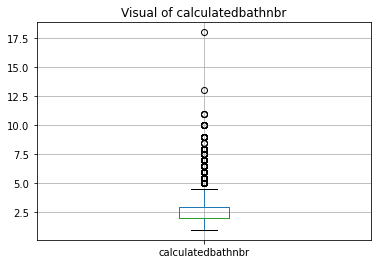

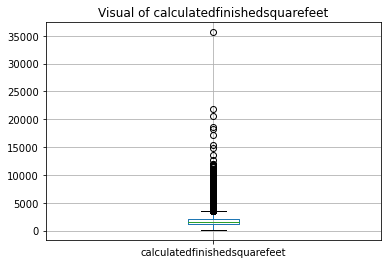

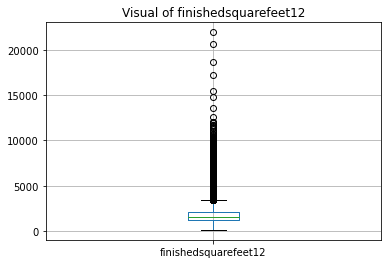

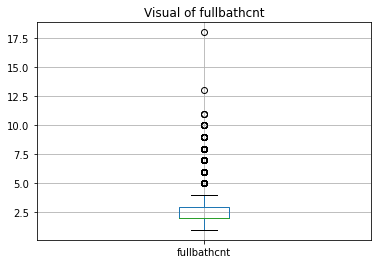

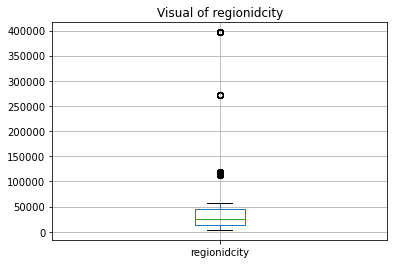

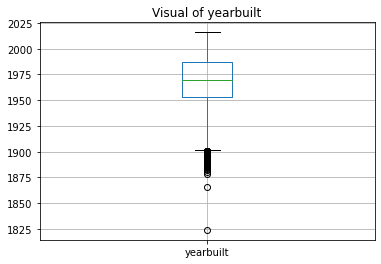

In [13]:
# show visuals for some numeral columns with nulls we need to impute
cols = df[['calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
           'fullbathcnt', 'regionidcity', 'yearbuilt']]
for i in cols:
    df.boxplot(column=[i])
    plt.title('Visual of '+i)
    plt.show()

This gives me a quick visual of how I want to impute some of my nulls. 
It also tells me there are a handful of outliers in my data I will need to address.

In [14]:
# fill my nulls using my impute function

# imputing discrete columns with most frequent value
df = wrangle.impute(df, 'most_frequent', ['calculatedfinishedsquarefeet', 'calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock'])
    
# imputing continuous columns with median value
df = wrangle.impute(df, 'median', ['finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'])

In [15]:
# verify my nulls are gone
df.isnull().sum()

propertylandusetypeid           0
parcelid                        0
transactiondate                 0
id                              0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
propertylandusedesc             0
dtype: int64

In [16]:
# view and remove my outliers from the visuals above


k = 1.5 # defines the upper and lower bound threshold
numerals = df[['calculatedfinishedsquarefeet', 'calculatedbathnbr', 'fullbathcnt', 'bathroomcnt',
               'bedroomcnt', 'latitude', 'longitude', 'regionidcity', 'regionidzip', 'yearbuilt', 
               'censustractandblock', 'finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt',
               'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']]


df = wrangle.remove_outliers(df, k, numerals)

For calculatedfinishedsquarefeet the lower bound is -205.0 and  upper bound is 3499.0
-----------------
Dataframe now has  73349 rows and  29 columns
For calculatedbathnbr the lower bound is 0.5 and  upper bound is 4.5
-----------------
Dataframe now has  73008 rows and  29 columns
For fullbathcnt the lower bound is 0.5 and  upper bound is 4.5
-----------------
Dataframe now has  73008 rows and  29 columns
For bathroomcnt the lower bound is 0.5 and  upper bound is 4.5
-----------------
Dataframe now has  72507 rows and  29 columns
For bedroomcnt the lower bound is -1.0 and  upper bound is 7.0
-----------------
Dataframe now has  72398 rows and  29 columns
For latitude the lower bound is 33277321.25 and  upper bound is 34715847.25
-----------------
Dataframe now has  72312 rows and  29 columns
For longitude the lower bound is -119127404.125 and  upper bound is -117215613.125
-----------------
Dataframe now has  70202 rows and  29 columns
For regionidcity the lower bound is -37068.0 and 

In [17]:
df.sample(3).T

,9578,30771,18494
propertylandusetypeid,261,261,261
parcelid,13885374,11660890,14076307
transactiondate,2017-02-14,2017-04-28,2017-03-20
id,1278284,1123061,279716
bathroomcnt,2,3,2
bedroomcnt,3,4,3
calculatedbathnbr,2,3,2
calculatedfinishedsquarefeet,1795,2765,1511
finishedsquarefeet12,1795,2765,1511
fips,6059,6037,6059


In [18]:
wrangle.value_counts(df, df.columns)

propertylandusetypeid
261.0    35611
266.0     8328
246.0     1413
269.0     1181
247.0      334
248.0      204
267.0       10
263.0       10
264.0        6
Name: propertylandusetypeid, dtype: int64
-------------
parcelid
12652542    1
14684345    1
11521363    1
10819097    1
11550029    1
           ..
14604839    1
12796573    1
11284583    1
12083865    1
10778081    1
Name: parcelid, Length: 47097, dtype: int64
-------------
transactiondate
2017-06-30    701
2017-04-28    553
2017-05-31    539
2017-07-28    481
2017-08-31    475
             ... 
2017-09-09      1
2017-04-08      1
2017-08-06      1
2017-04-23      1
2017-05-07      1
Name: transactiondate, Length: 254, dtype: int64
-------------
id
921163     1
626043     1
698276     1
234872     1
2944375    1
          ..
1155873    1
892779     1
44273      1
869149     1
1214036    1
Name: id, Length: 47097, dtype: int64
-------------
bathroomcnt
2.0    21753
1.0     9624
3.0     8915
2.5     4645
1.5     1115
4.0      857
3

Visual of distribution of bedroomcnt versus roomcnt


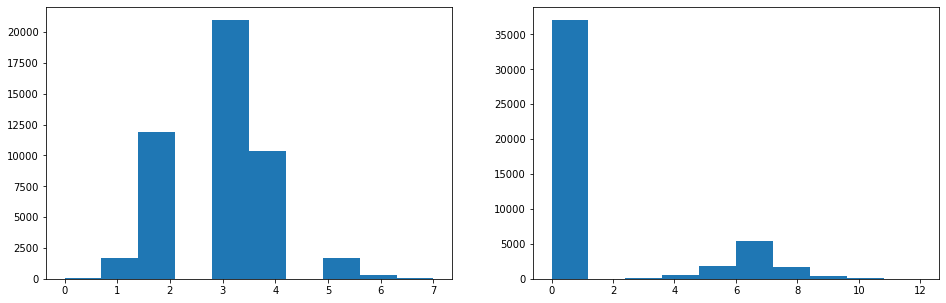

In [19]:
# visualize distributions of columns side by side to see is there are duplicates

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df.bedroomcnt)
plt.subplot(122)
plt.hist(df.roomcnt);
print('Visual of distribution of bedroomcnt versus roomcnt')

Visual of distribution of fips versus regionidcounty


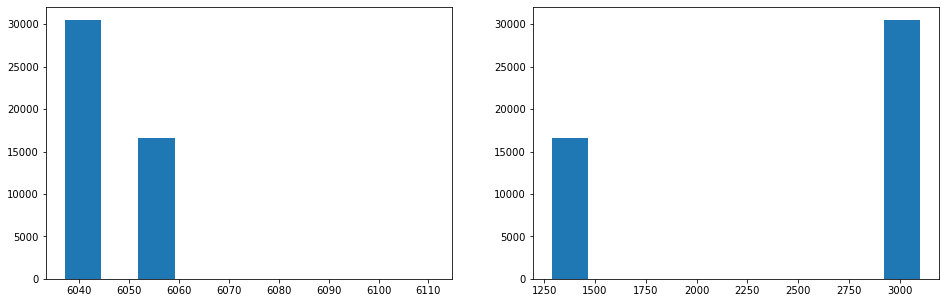

In [20]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df.fips)
plt.subplot(122)
plt.hist(df.regionidcounty)
print('Visual of distribution of fips versus regionidcounty');

Visual of distribution of fullbathcnt versus bathroomcnt


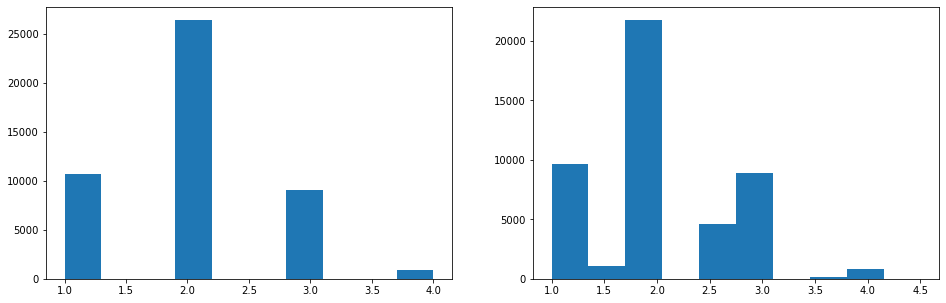

In [21]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df.fullbathcnt)
plt.subplot(122)
plt.hist(df.bathroomcnt);
print('Visual of distribution of fullbathcnt versus bathroomcnt')

Visual of distribution of structuretaxvaluedollarcnt versus taxamount


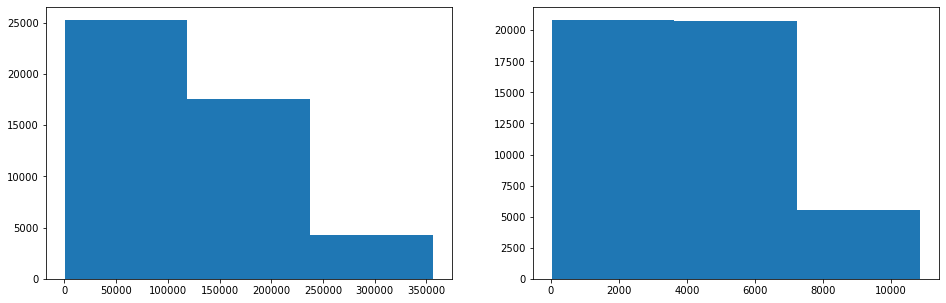

In [22]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df.structuretaxvaluedollarcnt, bins=3)
plt.subplot(122)
plt.hist(df.taxamount, bins=3);
print('Visual of distribution of structuretaxvaluedollarcnt versus taxamount')

Visual of distribution of landtaxvaluedollarcnt versus taxvaluedollarcnt


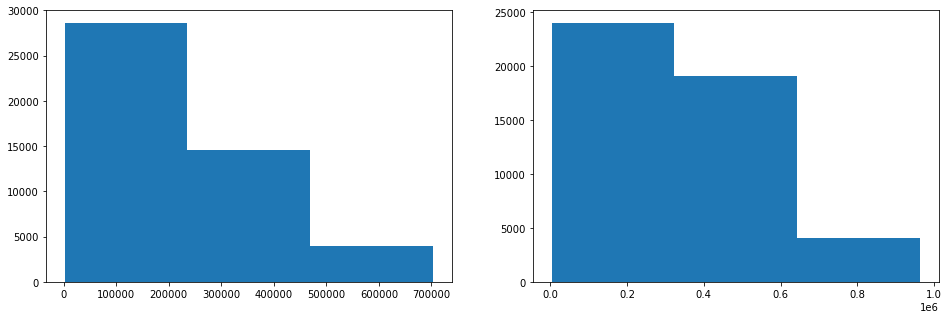

In [23]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df.landtaxvaluedollarcnt, bins=3)
plt.subplot(122)
plt.hist(df.taxvaluedollarcnt, bins=3);
print('Visual of distribution of landtaxvaluedollarcnt versus taxvaluedollarcnt')

Visual of distribution of regionidcounty versus regionidcity


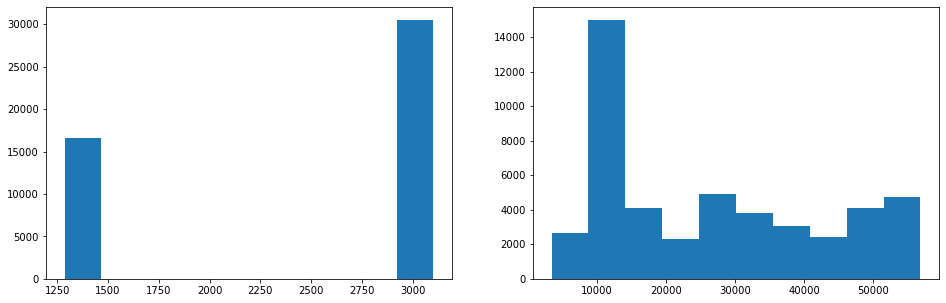

In [24]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df.regionidcounty)
plt.subplot(122)
plt.hist(df.regionidcity);
print('Visual of distribution of regionidcounty versus regionidcity')

In [25]:
# prepare and clean the dataframe using my clean_zillow funtion
df = wrangle.clean_zillow(df)

In [26]:
# split my data
train, validate, test = wrangle.split_data(df)

train---> (24604, 17)
validate---> (10545, 17)
test---> (8788, 17)


In [27]:
# scale my data
columns_to_scale = ['finished_sqft', 'total_lot_sqft', 'structure_tax_value',
                   'tax_value', 'tax_amount', 'home_age', 'tax_rate', 'price_per_sqft',
                   'longitude', 'latitude']
train_scaled, validate_scaled, test_scaled, scaler = wrangle.min_max_scaler(train, validate, test, columns_to_scale)

In [28]:
train_scaled.head().T

,70017,824,19908,702,17548
num_bathroom,3,2,3,3,2
num_bedroom,4,2,3,3,3
finished_sqft,0.647959,0.53207,0.465743,0.372813,0.420918
latitude,0.557546,0.584258,0.494199,0.547732,0.100584
longitude,0.626373,0.485806,0.81367,0.52283,0.893168
total_lot_sqft,0.500063,0.436442,0.539802,0.595211,0.592955
structure_tax_value,0.630811,0.5121,0.527342,0.42871,0.294793
tax_value,0.771231,0.839725,0.512661,0.466844,0.273522
tax_amount,0.895475,0.896164,0.578206,0.497506,0.30406
log_error,0.0970035,0.00559317,-0.052148,-0.046984,0.000839795


### Prepare Takeaways:
 - First, address my nulls by dropping and imputing.
 - Drop repetitive columns such as:
     - regionidcounty (same as FIPS)
     - fullbathcnt (same as bathroomcnt)
     - finishedsquarefeet12 (same as calculatedfinishedsquarefeet)
- Drop unnecessary columns such as:
    - roomcnt (most inputs are 0)
    - assessmentyear since all entries are 2016
- Drop mobile homes and town homes because this because an issue during splitting data since the amount is so low.
- Renamed my columns to be more legible.
- Added a home_age, abs_logerr, and price_per_sqft column
- Split my data for exploration.

# **Explore**
---

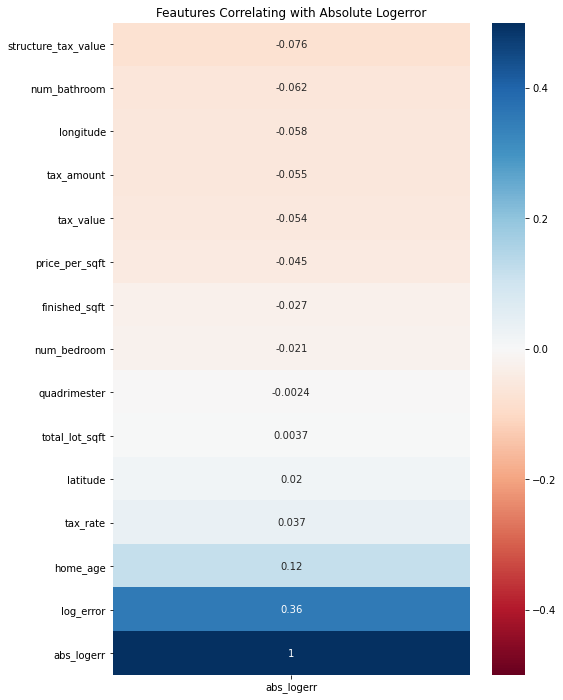

In [29]:
# Take a look at a heatmap of correlation to logerror
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train_scaled.corr()[['abs_logerr']].sort_values(by='abs_logerr', ascending=True), cmap="RdBu", vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Absolute Logerror')
plt.show()

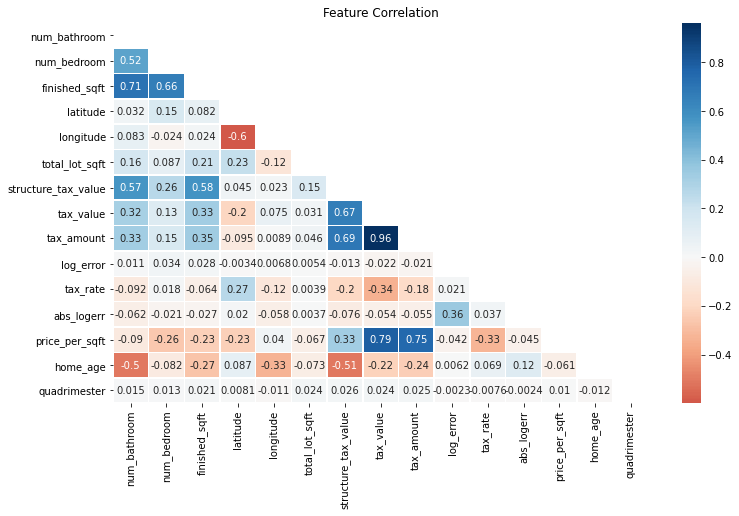

In [30]:
# Take a look at a correlation heatmap
numerical = train_scaled
corr = train_scaled.corr()
plt.figure(figsize=(12,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, annot=True, linewidths=.5, cmap="RdBu", mask=mask)
plt.title('Feature Correlation')
plt.show()

In [31]:
# take a look at value counts
wrangle.value_counts(train_scaled, train_scaled.columns)

num_bathroom
2.0    11409
1.0     5395
3.0     4252
2.5     2566
1.5      612
4.0      260
3.5      107
4.5        3
Name: num_bathroom, dtype: int64
-------------
num_bedroom
3.0    11204
2.0     6471
4.0     5211
1.0      868
5.0      738
6.0       77
0.0       26
7.0        9
Name: num_bedroom, dtype: int64
-------------
finished_sqft
0.318513    76
0.289359    68
0.274781    53
0.340379    53
0.453353    52
            ..
0.892857     1
0.807945     1
0.072157     1
0.892493     1
0.862974     1
Name: finished_sqft, Length: 2438, dtype: int64
-------------
latitude
0.237011    21
0.395344    13
0.207104    12
0.589011    12
0.215462    12
            ..
0.414064     1
0.475821     1
0.380862     1
0.991310     1
1.000000     1
Name: latitude, Length: 22577, dtype: int64
-------------
longitude
0.864924    21
0.761089    21
0.855196    20
0.333948    17
0.656587    17
            ..
0.692451     1
0.172367     1
0.625925     1
0.739085     1
1.000000     1
Name: longitude, Length: 2

In [32]:
train_scaled.head().T

,70017,824,19908,702,17548
num_bathroom,3,2,3,3,2
num_bedroom,4,2,3,3,3
finished_sqft,0.647959,0.53207,0.465743,0.372813,0.420918
latitude,0.557546,0.584258,0.494199,0.547732,0.100584
longitude,0.626373,0.485806,0.81367,0.52283,0.893168
total_lot_sqft,0.500063,0.436442,0.539802,0.595211,0.592955
structure_tax_value,0.630811,0.5121,0.527342,0.42871,0.294793
tax_value,0.771231,0.839725,0.512661,0.466844,0.273522
tax_amount,0.895475,0.896164,0.578206,0.497506,0.30406
log_error,0.0970035,0.00559317,-0.052148,-0.046984,0.000839795


Logerror versus num_bathroom


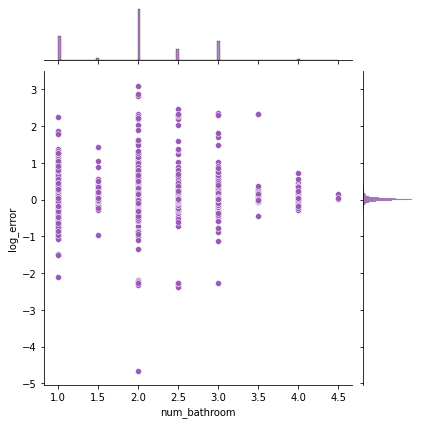

Logerror versus num_bedroom


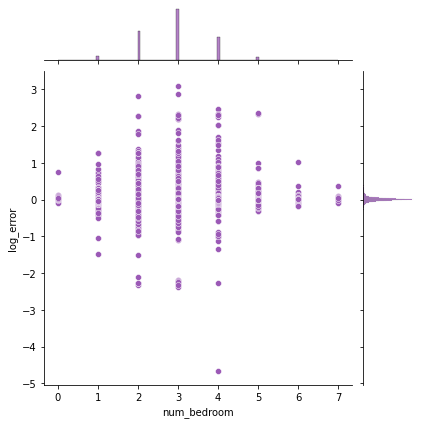

Logerror versus finished_sqft


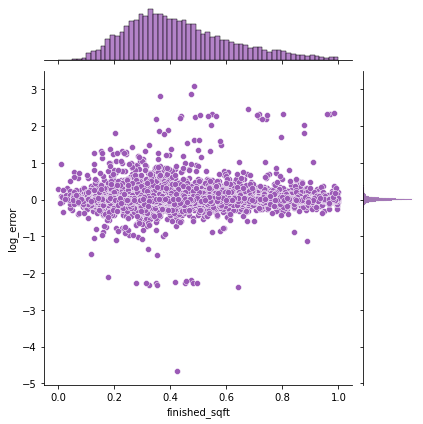

Logerror versus latitude


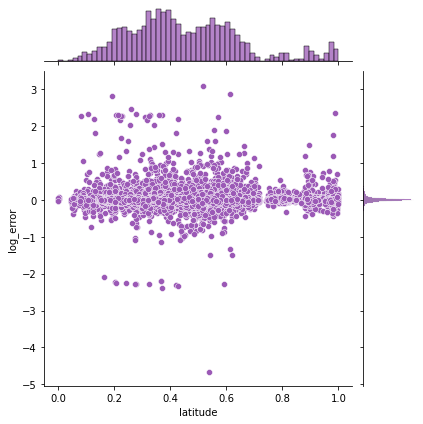

Logerror versus longitude


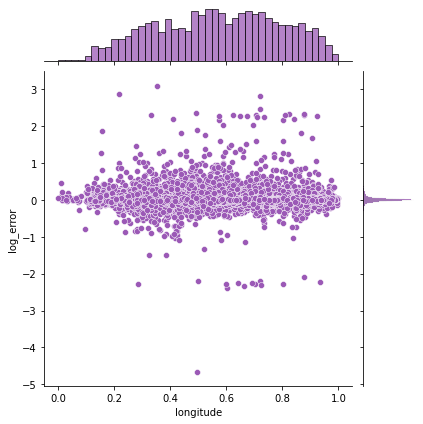

Logerror versus total_lot_sqft


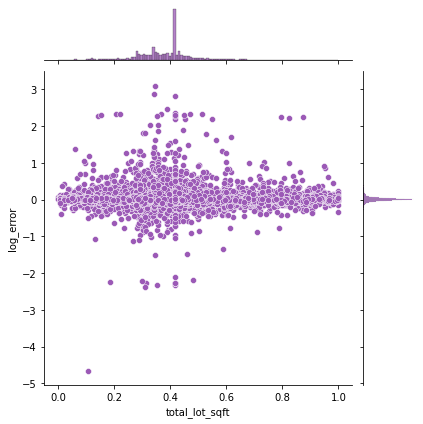

Logerror versus structure_tax_value


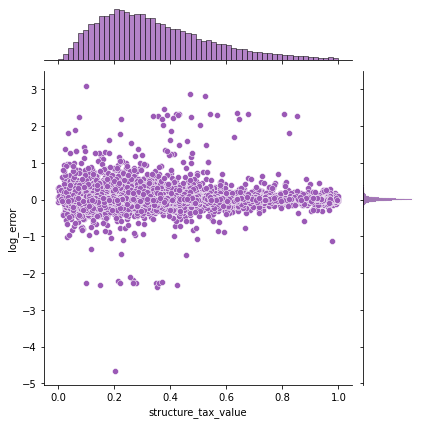

Logerror versus tax_value


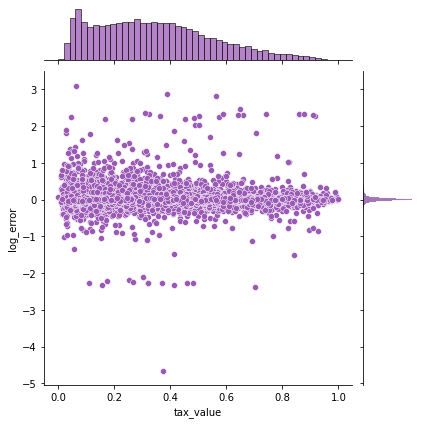

Logerror versus tax_amount


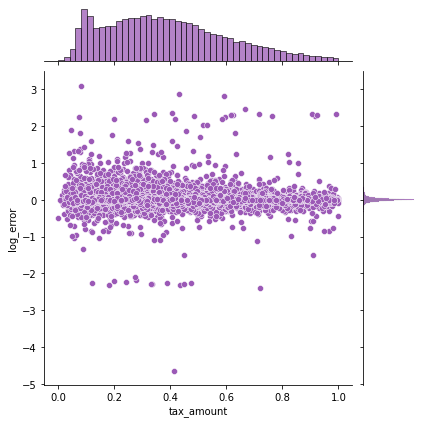

Logerror versus log_error


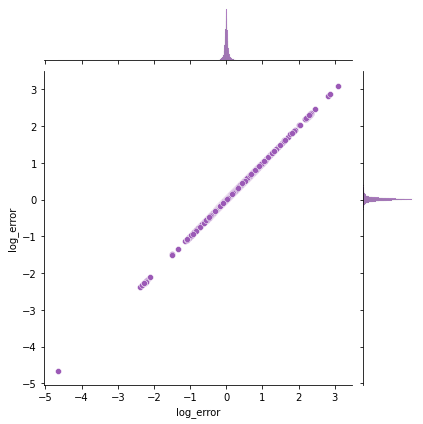

Logerror versus home_type


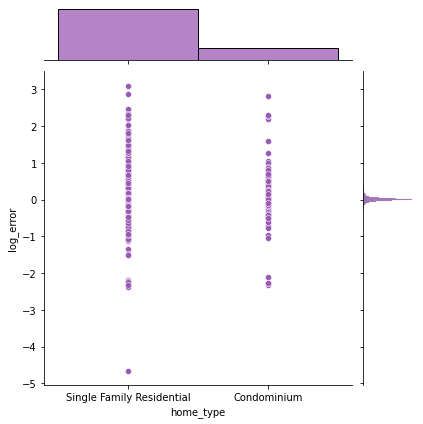

Logerror versus county


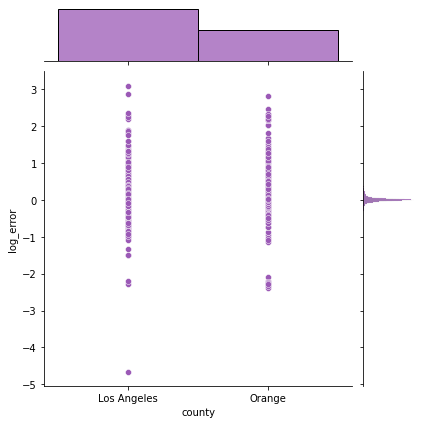

Logerror versus tax_rate


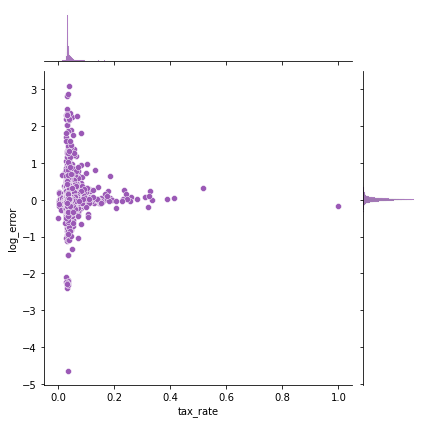

Logerror versus abs_logerr


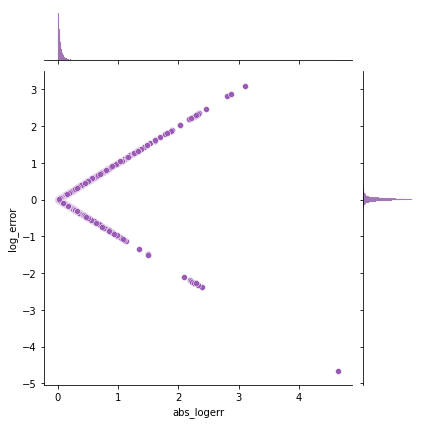

Logerror versus price_per_sqft


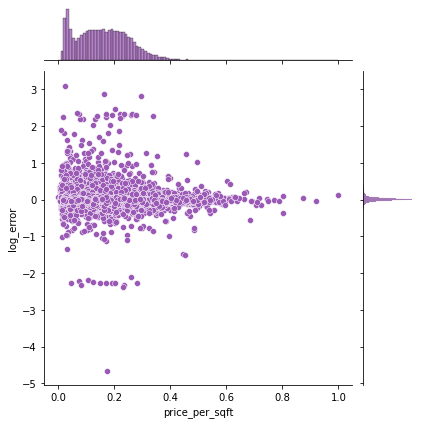

Logerror versus home_age


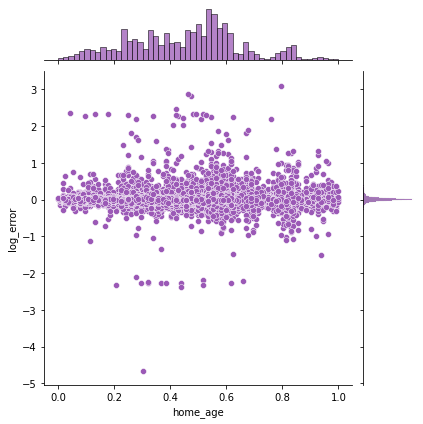

Logerror versus quadrimester


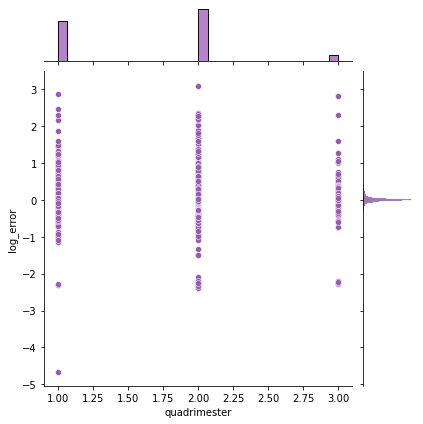

In [33]:
cols = train_scaled.columns
for i in cols:
    print('Logerror versus', i)
    sns.jointplot(x=i, y='log_error', data=train_scaled, color='#9b59b6')
    plt.xlabel(i)
    plt.ylabel('Absolute Logerror')
    plt.show()

In [34]:
# cols = train_scaled.columns
# for i in cols:
#     print('Absolute Logerror versus', i)
#     sns.jointplot(x=i, y='abs_logerr', data=train_scaled, color='#9b59b6')
#     plt.xlabel(i)
#     plt.ylabel('Absolute Logerror')
#     plt.show()

### Home Age versus Tax Rate

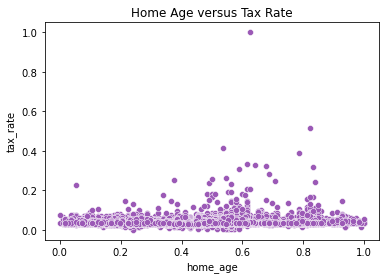

In [35]:
# take a look at a scatterplot for the two variables
sns.scatterplot(x='home_age', y='tax_rate', data=train_scaled, color='#9b59b6')
plt.title('Home Age versus Tax Rate');

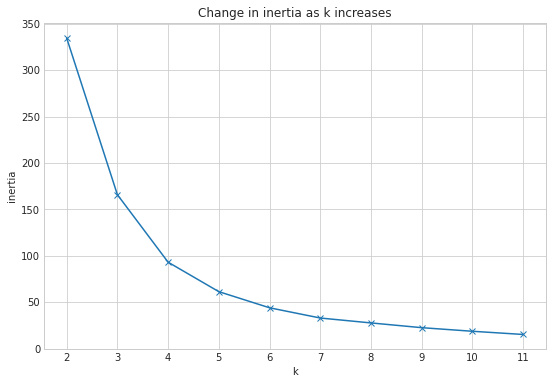

In [36]:
# which k to choose?

X = train_scaled[['home_age', 'tax_rate']]
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

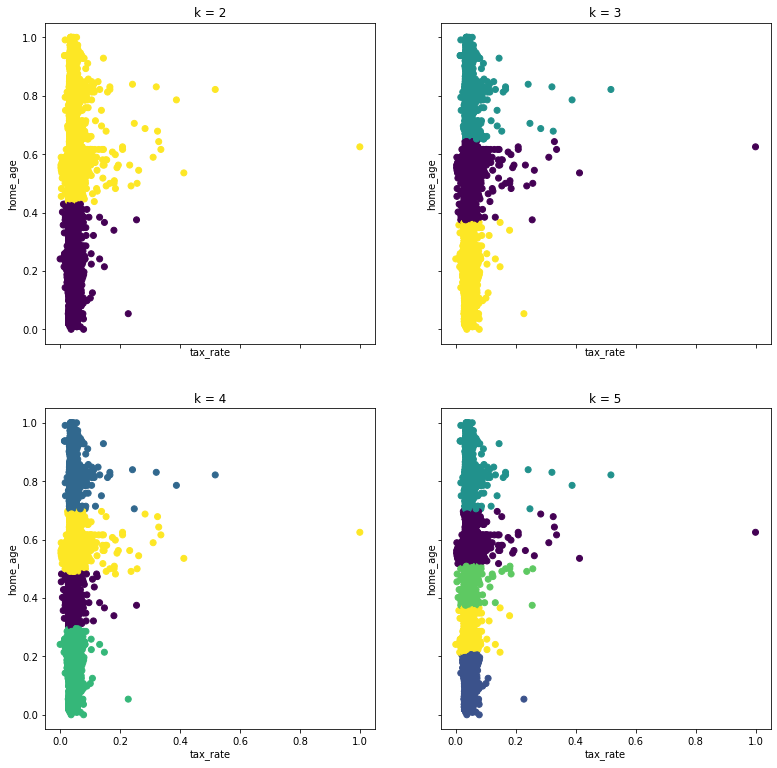

In [37]:
# visualize k for tax value and square feet
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.tax_rate, X.home_age, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='tax_rate', ylabel='home_age')

In [38]:
# k=4 makes the most sense here

# name the cluster column
cluster_name = 'age_tr_cluster'
# make four clusters
k = 4


# create a cluster column
X = train_scaled[['home_age', 'tax_rate']]
train_scaled, X, scaler, kmeans, centroids = explore.create_cluster(train_scaled, X, k, cluster_name)


# create the same clusters for validate
X = validate_scaled[['home_age', 'tax_rate']]
validate_scaled, X, scaler, kmeans, centroids = explore.create_cluster(validate_scaled, X, k, cluster_name)


# create the same clusters for validate
X = test_scaled[['home_age', 'tax_rate']]
test_scaled, X, scaler, kmeans, centroids = explore.create_cluster(test_scaled, X, k, cluster_name)

train_scaled.shape, validate_scaled.shape, test_scaled.shape

((24604, 18), (10545, 18), (8788, 18))

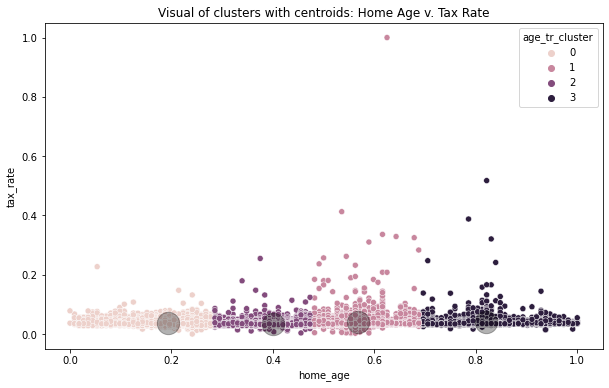

In [39]:
explore.create_cluster_scatter_plot('home_age', 'tax_rate', train_scaled, X, kmeans, scaler, cluster_name)
plt.title('Visual of clusters with centroids: Home Age v. Tax Rate');

**Takeaways:**
\
    - This appears to be a useful set of clusters we can use for our model.
    - Cluster 3 appears to have the highest correlation to tax_rate.

### Latitude versus Finished Squarefeet

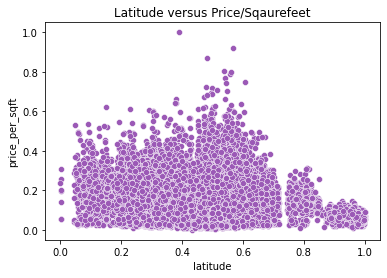

In [40]:
# now let's take a look at latitude versus finished squarefeet, are there larger homes in different areas?
sns.scatterplot(x='latitude', y='price_per_sqft', data=train_scaled, color='#9b59b6')
plt.title('Latitude versus Price/Sqaurefeet');

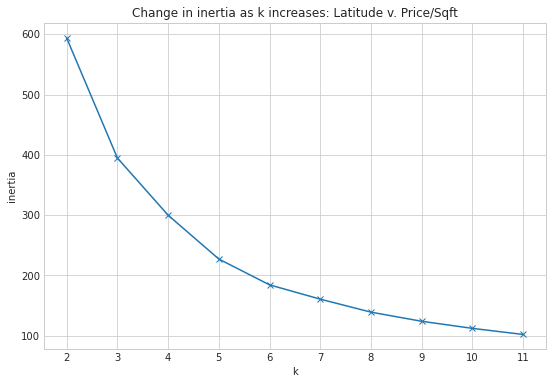

In [41]:
# which k to choose?

X = train_scaled[['latitude', 'price_per_sqft']]
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases: Latitude v. Price/Sqft')

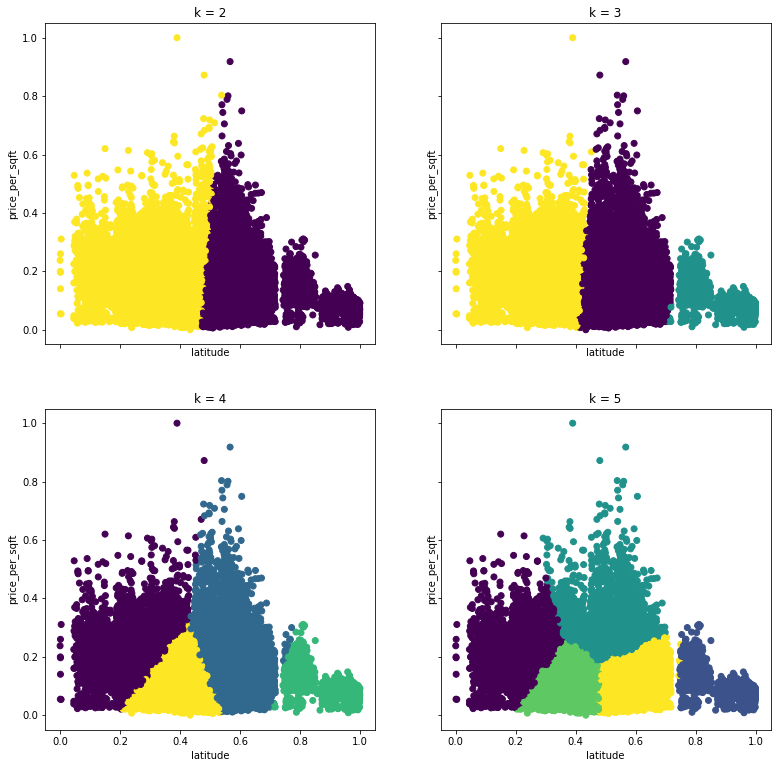

In [42]:
# visualize k for latitude and price per square feet
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.latitude, X.price_per_sqft, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='latitude', ylabel='price_per_sqft')

(24604, 19) (10545, 19) (8788, 19)


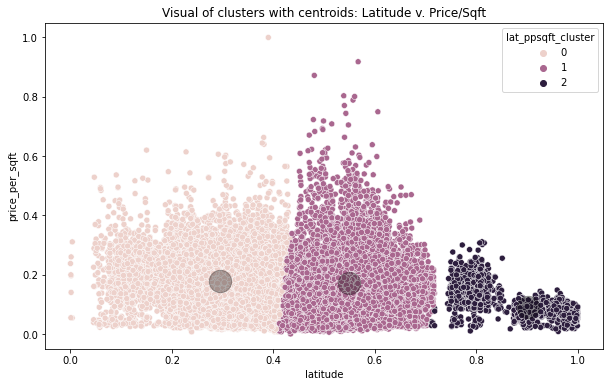

In [43]:
# k = 3 makes the most sense here

# name cluster column
cluster_name = 'lat_ppsqft_cluster'

# assign k=3 for three clusters
k = 3


# create column on train dataframe
X = train_scaled[['latitude', 'price_per_sqft']]
train_scaled, X, scaler, kmeans, centroids = explore.create_cluster(train_scaled, X, k, cluster_name)


# create column on validate dataframe
X = validate_scaled[['latitude', 'price_per_sqft']]
validate_scaled, X, scaler, kmeans, centroids = explore.create_cluster(validate_scaled, X, k, cluster_name)


# create column on test dataframe
X = test_scaled[['latitude', 'price_per_sqft']]
test_scaled, X, scaler, kmeans, centroids = explore.create_cluster(test_scaled, X, k, cluster_name)

print(train_scaled.shape, validate_scaled.shape, test_scaled.shape)

# create visual
explore.create_cluster_scatter_plot('latitude', 'price_per_sqft', train_scaled, X, kmeans, scaler, cluster_name)
plt.title('Visual of clusters with centroids: Latitude v. Price/Sqft');

**Takeaways:**
\
    - This set of cluster may not have much going on here.
    - A heatmap may tell us more.
    

### Tax Amount versus Structure Tax Value

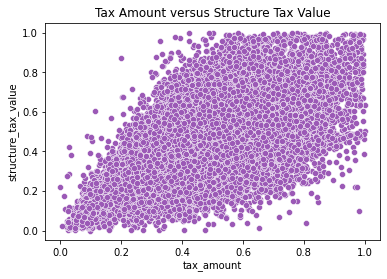

In [44]:
# take a look at a scatterplot for tax amount versus structure tax value
sns.scatterplot(x='tax_amount', y='structure_tax_value', data=train_scaled, color='#9b59b6')
plt.title('Tax Amount versus Structure Tax Value');

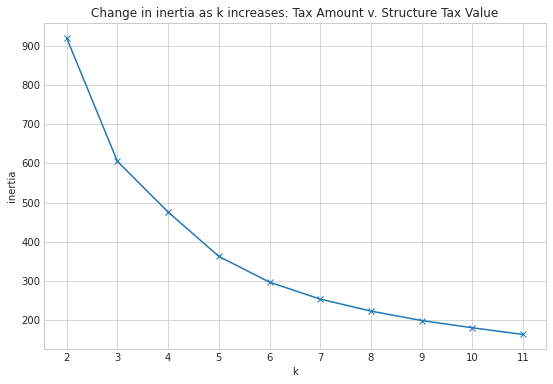

In [45]:
# which k to choose?

X = train_scaled[['tax_amount', 'structure_tax_value']]
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases: Tax Amount v. Structure Tax Value')

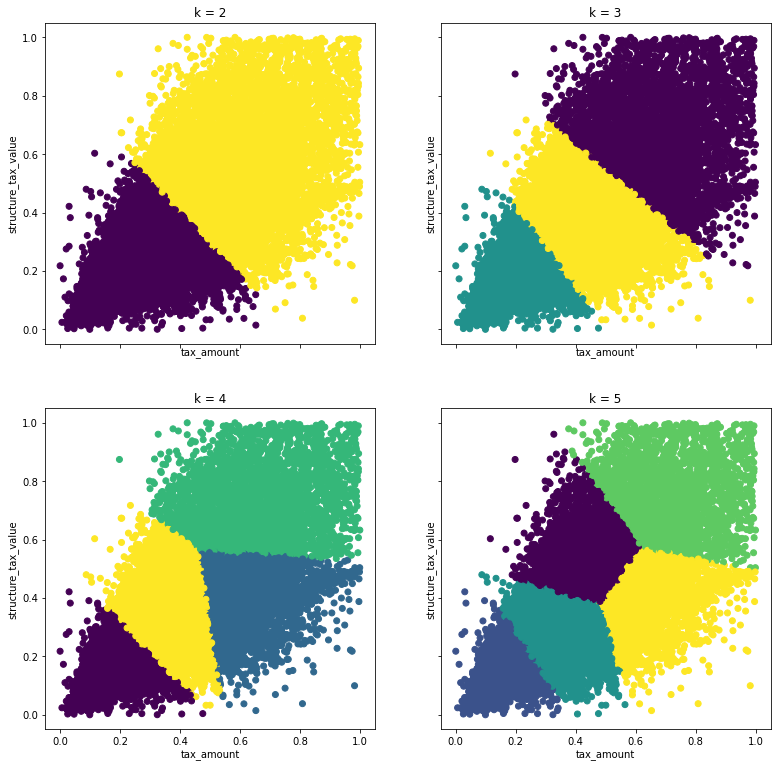

In [46]:
# visualize k for tax amount and structure tax value
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.tax_amount, X.structure_tax_value, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='tax_amount', ylabel='structure_tax_value')

(24604, 20) (10545, 20) (8788, 20)


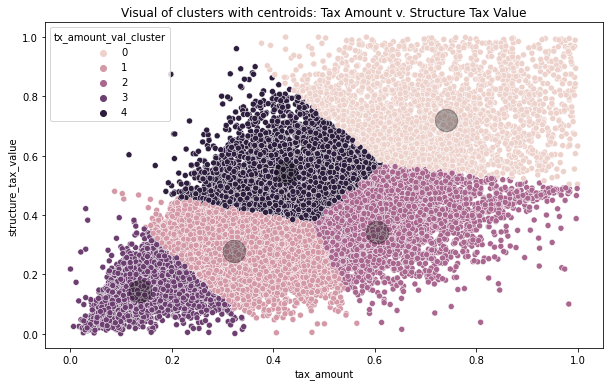

In [47]:
# k = 5 makes the most sense here

# name cluster column
cluster_name = 'tx_amount_val_cluster'
# use k=5 for five clusters
k = 5


# create cluster column on train dataframe
X = train_scaled[['tax_amount', 'structure_tax_value']]
train_scaled, X, scaler, kmeans, centroids = explore.create_cluster(train_scaled, X, k, cluster_name)


# create cluster column on validate dataframe
X = validate_scaled[['tax_amount', 'structure_tax_value']]
validate_scaled, X, scaler, kmeans, centroids = explore.create_cluster(validate_scaled, X, k, cluster_name)


# create cluster column on test dataframe
X = test_scaled[['tax_amount', 'structure_tax_value']]
test_scaled, X, scaler, kmeans, centroids = explore.create_cluster(test_scaled, X, k, cluster_name)


print(train_scaled.shape, validate_scaled.shape, test_scaled.shape)


explore.create_cluster_scatter_plot('tax_amount', 'structure_tax_value', train_scaled, X, kmeans, scaler, cluster_name)
plt.title('Visual of clusters with centroids: Tax Amount v. Structure Tax Value');

**Takeaways:**
\
    - While this is a messy set of clusters, this may be of use here for modeling.

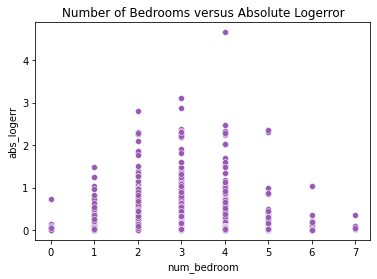

In [48]:
# take a look at correlation between bedrooms and logerror to assess whether binning may be a good idea
sns.scatterplot(x='num_bedroom', y='abs_logerr', data=train_scaled, color='#9b59b6')
plt.title('Number of Bedrooms versus Absolute Logerror');

${H_0}$ = The mean of absolute logerror for 1-3 bedroom homes == the mean of abs logerror for 4+ bedrooms home.
\
${H_a}$ = The mean of absolute logerror for 1-3 bedroom homes < the mean of abs logerror for 4+ bedrooms home.

In [49]:
# set our confidence level
conf_int = .95

# assign our alpha based on confidence level
alpha = 1 - conf_int

# set up my samples
sample1 = train_scaled[train_scaled['num_bedroom']<4].abs_logerr
sample2 = train_scaled[train_scaled['num_bedroom']>3].abs_logerr

# let's check the variance to confirm equality
sample1.var(), sample2.var()

(0.01967156313708083, 0.024019811532660768)

In [50]:
# there is not much differencein variance so we will set equal_var to true
t, p = stats.ttest_ind(sample1, sample2, equal_var=True)

if (p/2 < alpha) & (t > 0):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


So since we fail to reject ${H_0}$, there is reason to believe the mean of abs logerror of more bedroom homes is the same as lesser bedroom homes. 
\
This confirms that binning the bedrooms column will not affect my model negatively.

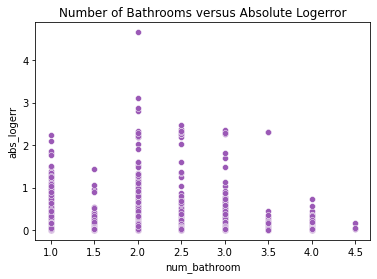

In [51]:
# let's do the same exact for bathrooms now and see if binning may be a good idea

sns.scatterplot(x='num_bathroom', y='abs_logerr', data=train_scaled, color='#9b59b6')
plt.title('Number of Bathrooms versus Absolute Logerror');

${H_0}$ = The mean of absolute logerror for 1-2.5 bathroom homes == the mean of abs logerror for 3+ bedrooms home.
\
${H_a}$ = The mean of absolute logerror for 1-2.5 bedroom homes < the mean of abs logerror for 3+ bedrooms home.

In [52]:
# set our confidence level
conf_int = .95

# assign our alpha based on confidence level
alpha = 1 - conf_int

# set up my samples
sample1 = train_scaled[train_scaled['num_bathroom']<3].abs_logerr
sample2 = train_scaled[train_scaled['num_bathroom']>2.5].abs_logerr

# let's check the variance to confirm equality
sample1.var(), sample2.var()

(0.022022407315709334, 0.01511805477099093)

In [53]:
# there is not much differencein variance so we will set equal_var to true
t, p = stats.ttest_ind(sample1, sample2, equal_var=True)

if (p/2 < alpha) & (t > 0):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


So since we fail to reject ${H_0}$, there is reason to believe the mean of abs logerror of 3+ bathroom homes is the same as lesser bathroom homes. 
\
This confirms that binning the bathrooms column will not affect my model negatively.

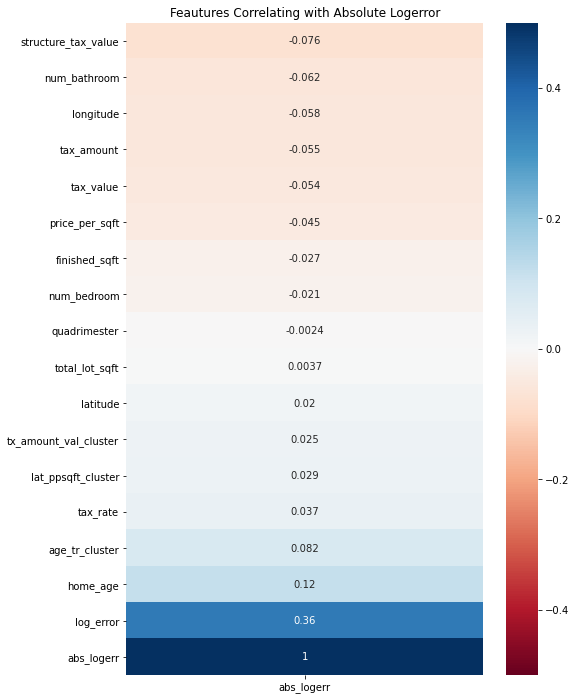

In [54]:
# Take a look at a heatmap of correlation to tax value
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train_scaled.corr()[['abs_logerr']].sort_values(by='abs_logerr', ascending=True), cmap="RdBu", vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Absolute Logerror')
plt.show()

In [55]:
# Here I bin my data and separate columns for houses with 3 or less bedrooms and 4 or more bedrooms
# For bathrooms I bin them as 2.5 or less bathroom homes and 3 or more bathroom homes.

train_scaled['three_bed_less'] = np.where(train_scaled['num_bedroom']<4,1,0)
train_scaled['four_bed_more'] = np.where(train_scaled['num_bedroom']>3,1,0)

validate_scaled['three_bed_less'] = np.where(validate_scaled['num_bedroom']<4,1,0)
validate_scaled['four_bed_more'] = np.where(validate_scaled['num_bedroom']>3,1,0)

test_scaled['three_bed_less'] = np.where(test_scaled['num_bedroom']<4,1,0)
test_scaled['four_bed_more'] = np.where(test_scaled['num_bedroom']>3,1,0)

# ---------

train_scaled['twohalf_bath_less'] = np.where(train_scaled['num_bathroom']<3,1,0)
train_scaled['three_bath_more'] = np.where(train_scaled['num_bathroom']>=3,1,0)

validate_scaled['twohalf_bath_less'] = np.where(validate_scaled['num_bathroom']<3,1,0)
validate_scaled['three_bath_more'] = np.where(validate_scaled['num_bathroom']>=3,1,0)

test_scaled['twohalf_bath_less'] = np.where(test_scaled['num_bathroom']<3,1,0)
test_scaled['three_bath_more'] = np.where(test_scaled['num_bathroom']>=3,1,0)

train_scaled.shape, validate_scaled.shape, test_scaled.shape

((24604, 24), (10545, 24), (8788, 24))

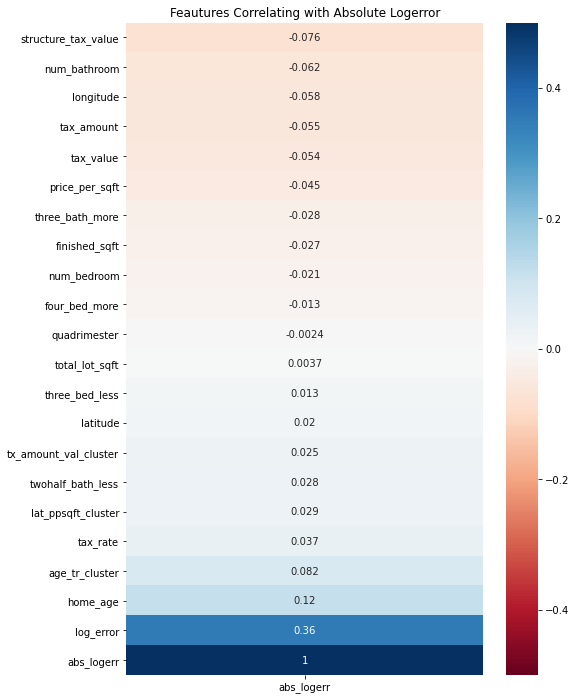

In [56]:
# Take another look at a heatmap of correlation to logerror
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train_scaled.corr()[['abs_logerr']].sort_values(by='abs_logerr', ascending=True), cmap="RdBu", vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Absolute Logerror')
plt.show()

In [57]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((24604, 24), (10545, 24), (8788, 24))

### Explore Takeaways:
- Use asolute log error to visualize correlations between dependent and independent variables using heatmaps.
- Used jointplots to visualize correlations and possible clusters.
- Created three clusters:
    - Home Age v. Tax Rate
    - Latitude v. Finished Sqft
    - Tax Amount v. Structure Tax Value
- Used statistical testing to assess how to bin columns.
- Binned bedroom and bathroom columns.

# **Modeling**

In [58]:
# choose my top features
top_features = ['home_age', 'age_tr_cluster', 'structure_tax_value',
                'longitude', 'tax_amount', 'tax_value', 'price_per_sqft', 'quadrimester',
               'three_bath_more', 'twohalf_bath_less', 'four_bed_more', 'three_bed_less']


# assign my x_df and y_df
X_train, y_train = train_scaled[top_features], train_scaled.log_error
X_validate, y_validate = validate_scaled[top_features], validate_scaled.log_error
X_test, y_test = test_scaled[top_features], test_scaled.log_error

In [59]:
# create necessary dummy columns or my model

dummy_cols = ['quadrimester', 'age_tr_cluster']

# create dummy columns on each X dataframe
X_train = pd.get_dummies(columns=dummy_cols, data=X_train, drop_first=True)
X_validate = pd.get_dummies(columns=dummy_cols, data=X_validate, drop_first=True)
X_test = pd.get_dummies(columns=dummy_cols, data=X_test, drop_first=True)

X_train.shape, X_validate.shape, X_test.shape

((24604, 15), (10545, 15), (8788, 15))

### Baseline Model

In [60]:
# create dataframes out of my y dataframes
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)


# 1. Predict log error_baseline mean
baseline_mean = y_train['log_error'].mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean


# 3. RMSE of log error mean
rmse_train = mean_squared_error(y_train.log_error, y_train.baseline_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.baseline_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.17


So now, we just have to explore and create other models that can hopefully predict our baseline model.

### Model #1 (Linear Regression)

In [61]:
# create the model object
lm = LinearRegression(normalize=True)

explore.rmse(lm, X_train, X_validate, y_train, y_validate, 'log_error', 'model1_lr')

RMSE for model1_lr using LinearRegression(normalize=True) 
Training/In-Sample:  0.15707482147774343 
Validation/Out-of-Sample:  0.1717628780012712



(0.15707482147774343, 0.1717628780012712)

Model 1 does not appear to be much better than the baseline.

### Model #2 (LassoLars)

In [62]:
# create the model object
lars = LassoLars(alpha=1.0)

explore.rmse(lars, X_train, X_validate, y_train, y_validate, 'log_error', 'model2_lars')

RMSE for model2_lars using LassoLars() 
Training/In-Sample:  0.15733988937296609 
Validation/Out-of-Sample:  0.1714100839523809



(0.15733988937296609, 0.1714100839523809)

Model 2 is performing no better than the Model 1 using Linear Regression

### Model 3 (Polynomial Regression)

In [63]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

lm2 = LinearRegression(normalize=True)

# fit and transform X_train_scaled
X_train2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate2 = pf.transform(X_validate)

explore.rmse(lm2, X_train2, X_validate2, y_train, y_validate, 'log_error', 'model3_pf')

RMSE for model3_pf using LinearRegression(normalize=True) 
Training/In-Sample:  0.15670733451266303 
Validation/Out-of-Sample:  0.1789581566747246



(0.15670733451266303, 0.1789581566747246)

Again this model appears to be similar to the other model, not performing much better than the baseline.

### Model 4 (Polynomial Regression)

In [64]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate3 = pf.transform(X_validate)


lm3 = LinearRegression(normalize=True)

explore.rmse(lm3, X_train3, X_validate3, y_train, y_validate, 'log_error', 'model4_pf')

RMSE for model4_pf using LinearRegression(normalize=True) 
Training/In-Sample:  0.1557576829480507 
Validation/Out-of-Sample:  0.30739287863241543



(0.1557576829480507, 0.30739287863241543)

This model does well on train set but likely overfit with such a high validate score.\
My takeaway is that we move forward with Model 3, the PolynomialRegression model to test on the test dataframe.

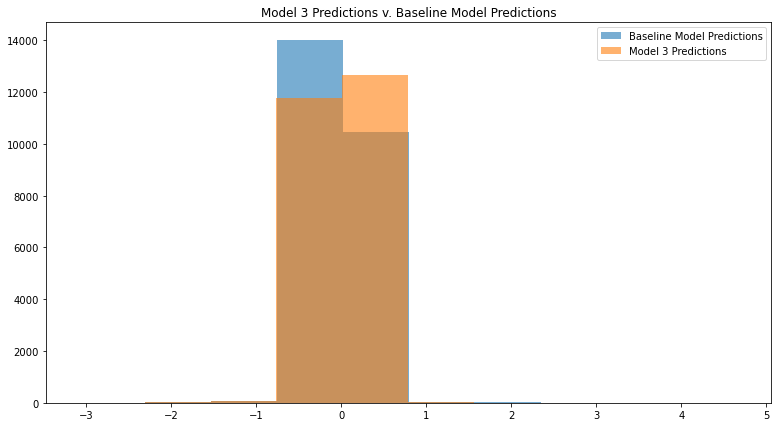

In [65]:
# let's take a look at the graph of residuals for the baseline model

# create a residual column
X_train['residual'] = (y_train.model3_pf - y_train.log_error)

# create a residual baseline column
X_train['residual_mean_baseline'] = (y_train.log_error.mean() - y_train.log_error)
    
fig, ax = plt.subplots(figsize=(13,7))

ax.hist(X_train.residual_mean_baseline, label='Baseline Model Predictions', alpha=.6)
ax.hist(X_train.residual, label='Model 3 Predictions', alpha=.6)
ax.legend()

plt.title('Model 3 Predictions v. Baseline Model Predictions')
plt.show()

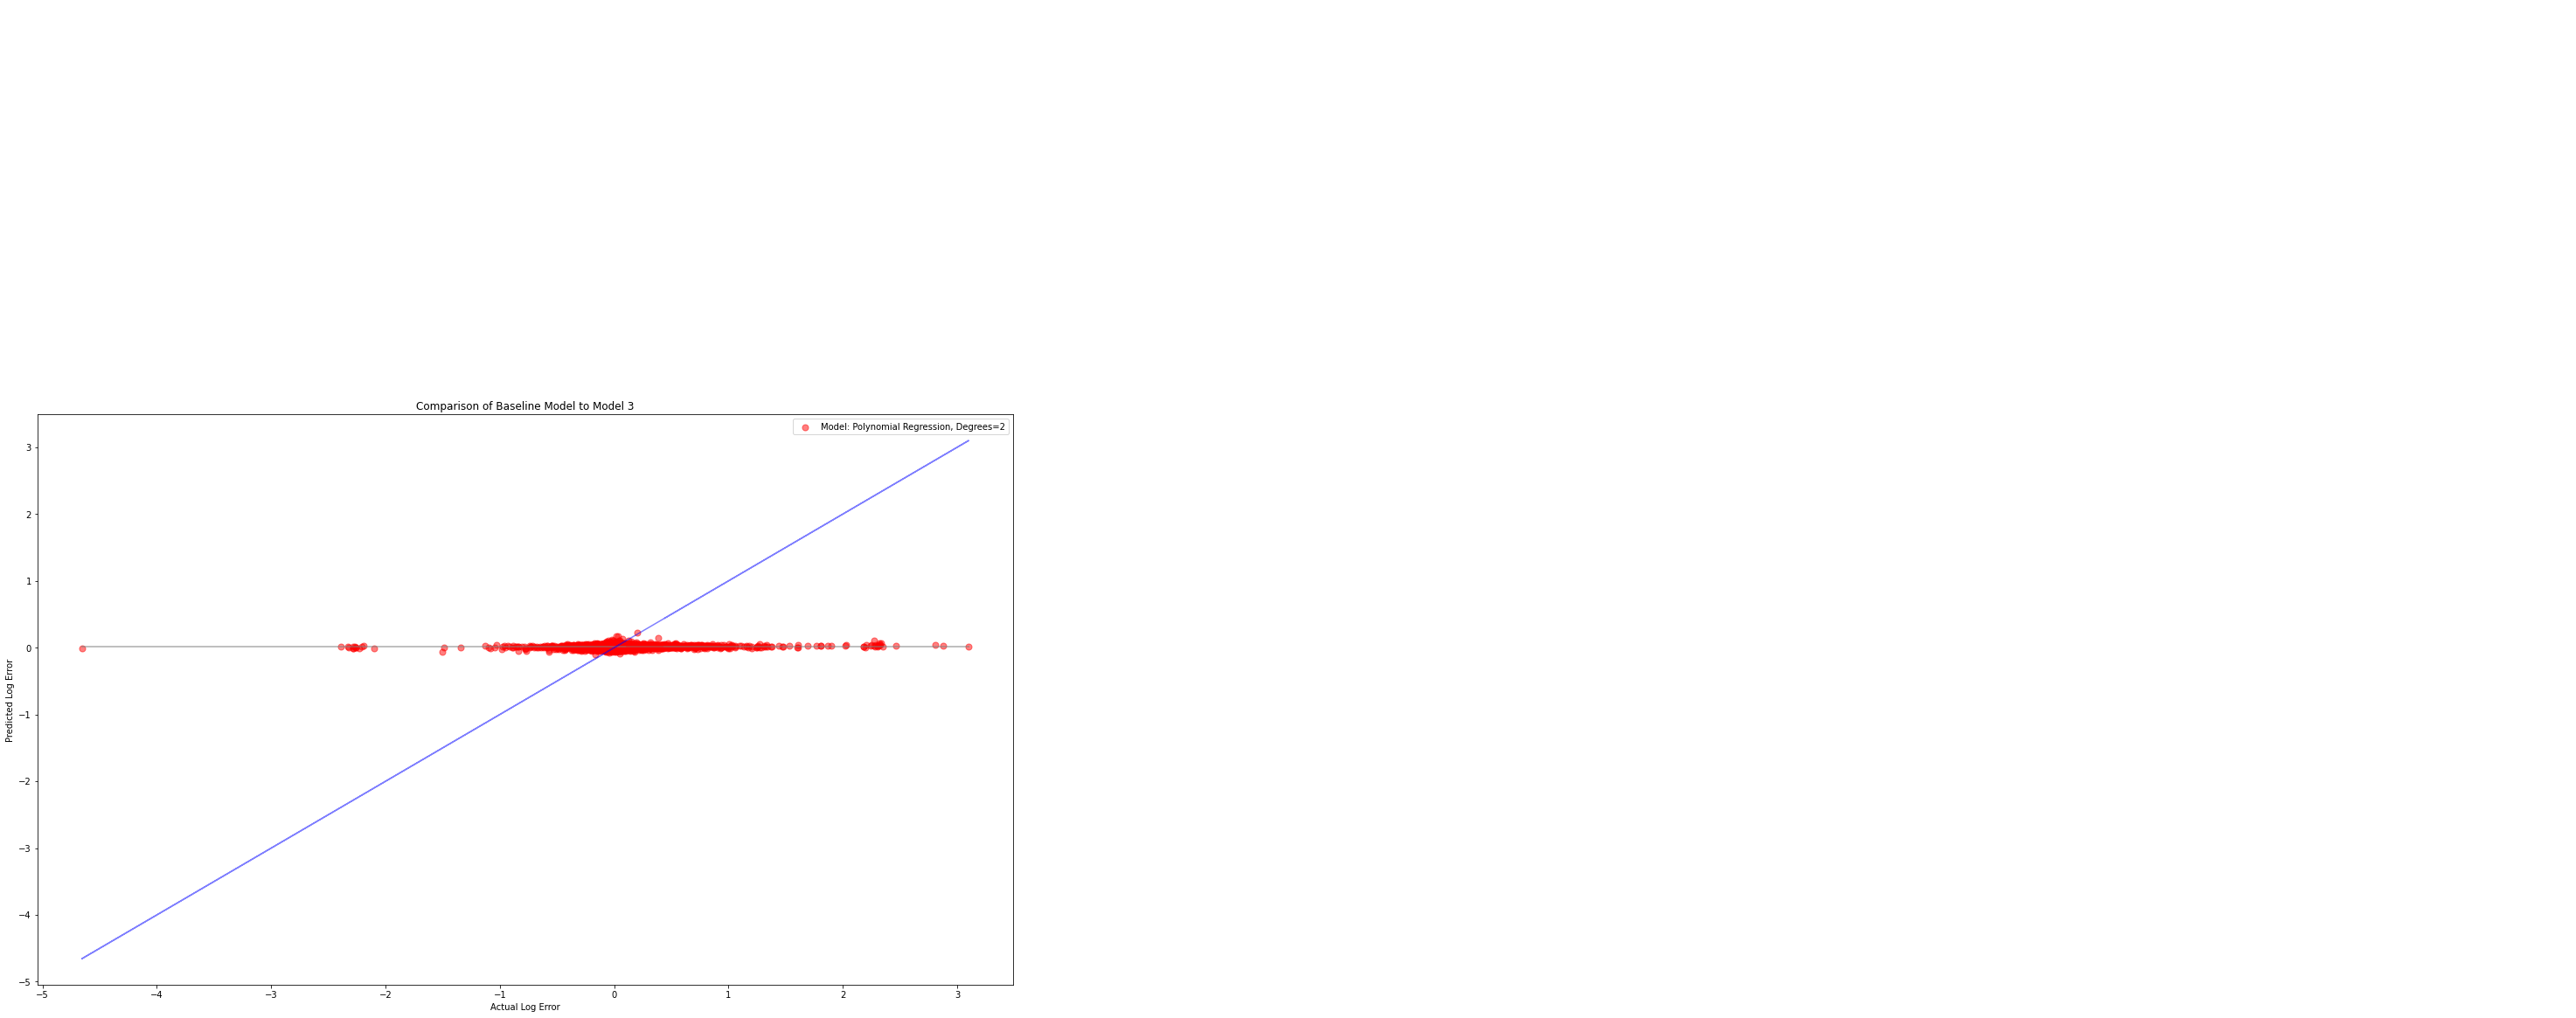

In [66]:
# another look at plotting residual

plt.figure(figsize=(20,12))
plt.plot(y_train.log_error, y_train.baseline_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))

plt.plot(y_train.log_error, y_train.log_error, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_train.log_error, y_train.model3_pf,
            alpha=.5, color="red", s=50, label="Model: Polynomial Regression, Degrees=2")



plt.legend()
plt.xlabel("Actual Log Error")
plt.ylabel("Predicted Log Error")
plt.title("Comparison of Baseline Model to Model 3")

plt.show()

**Test Model 3**

In [67]:
# drop the residual columns I created
cols = ['residual', 'residual_mean_baseline']
X_train.drop(columns=cols, inplace=True)
X_train.shape, X_validate.shape, X_test.shape

((24604, 15), (10545, 15), (8788, 15))

In [68]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

lm2 = LinearRegression(normalize=True)

# fit and transform X_train_scaled
X_train2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate2 = pf.transform(X_validate)


explore.rmse(lm2, X_train2, X_validate2, y_train, y_validate, 'log_error', 'model3_pf')

# transform on test dataset and create column for prediction
X_test2 = pf.transform(X_test)
y_test['model3_pf'] = lm2.predict(X_test2)

RMSE for model3_pf using LinearRegression(normalize=True) 
Training/In-Sample:  0.15670733451266303 
Validation/Out-of-Sample:  0.1789581566747246



In [69]:
# evaluate: rmse for train
rmse_train = mean_squared_error(y_train['log_error'], y_train['model3_pf'])**(1/2)

# evaluate: rmse for validate
rmse_validate = mean_squared_error(y_validate['log_error'], y_validate['model3_pf'])**(1/2)

# evaluate RMSE for test
rmse_test = mean_squared_error(y_test['log_error'], y_test['model3_pf'])**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nTest/Out-of-Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.15670733451266303 
Validation/Out-of-Sample:  0.1789581566747246 
Test/Out-of-Sample:  0.14660995602675533


### Modeling Takeaways:
- Used mean average log error for baseline model
    - RMSE on train = .16
    - RMSE on validate = .17
- Four other models created, Model 3 PolynomialRegression beat by baseline by a fraction.
- Used Model 3 on test data set and achieved a low RMSE of .14.
- In the end, Model 3 performed fairly well on the test data set.

# Conclusions:
- I acquired and prepped my data accordingly by addressing nulls and outliers and removing duplicate columns.
- I was able to explore through visualizations and statistical testing to help pin point drivers of log error.
- I also utilized custering methods to create clusters to use in modeling.
- I created four models in addition to the baseline using the mean average of log error.
- In the end, Model 3 using Polynomial Regressor narrowly beat the baseline model.
- Model 3 did perform very well on the unseen test data set with RMSE of .14.

### With more time:
 - I would test different features in my model to see which can achieve a better RMSE.
 - I may change my binning methods to see if others give me a better correlation.
 - Create clusters with latitude and longitude.
 - Dive deeper into the location of the homes using lat/long.